In [65]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable
import cvxpy as cp

from eos import EosProperties
from kernels import Kernel
import gaussianprocess
import constrainedgp as cgp
import finitedimensionalgp as fdgp
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns
import virtobs as vo
import tmg_samplers as tmg

from pathlib import Path
notebook_dir = Path.cwd()

from scipy.linalg import cholesky, solve_triangular, cho_solve
from scipy.stats import norm
import scipy as sp
import pandas as pd


from aquarel import load_theme
theme = (
        load_theme("gruvbox_dark")
        .set_font("serif")
        .set_grid(True, width=0.2)
        )

theme.apply()

In [71]:
def l_m52(l):
    return 1.16084*l
def l_m32(l):
    return 1.27575*l

In [67]:
n = np.linspace(0.04, 10, num=200)

In [74]:
l_s = 0.75
l_me52 = l_m52(l_s)
l_me32 = l_m32(l_s)

In [77]:
l_m52(1.5)

1.74126

### prior covs

In [57]:
kern_se = Kernel('SE', sigma=1, l=l_s)
kern_me52 = Kernel('M52', sigma=1, l=l_m52)
kern_me32 = Kernel('M32', sigma=1, l=l_m32)


In [58]:
cov_se = kern_se.compute(n)
cov_me52 = kern_me52.compute(n)
cov_me32 = kern_me32.compute(n)

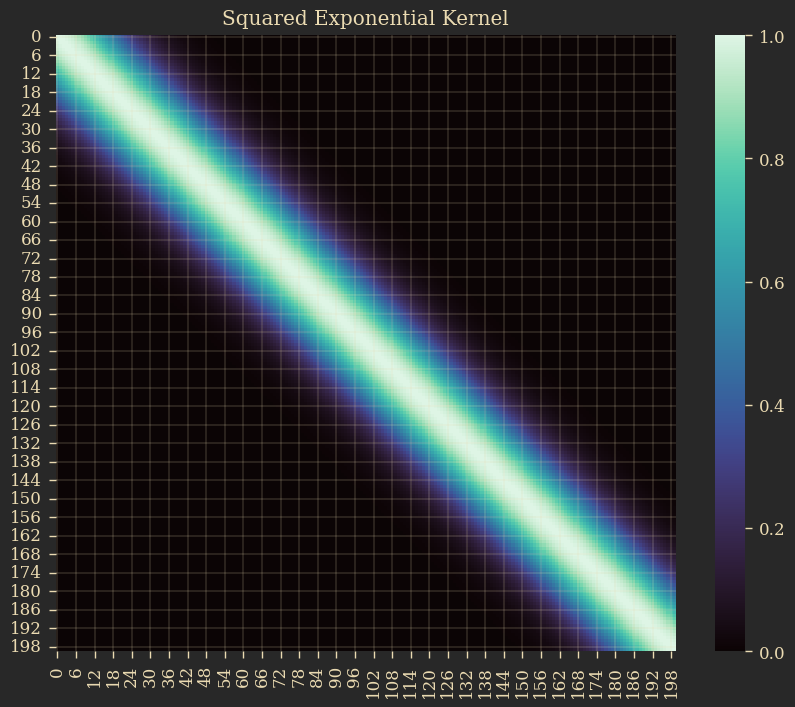

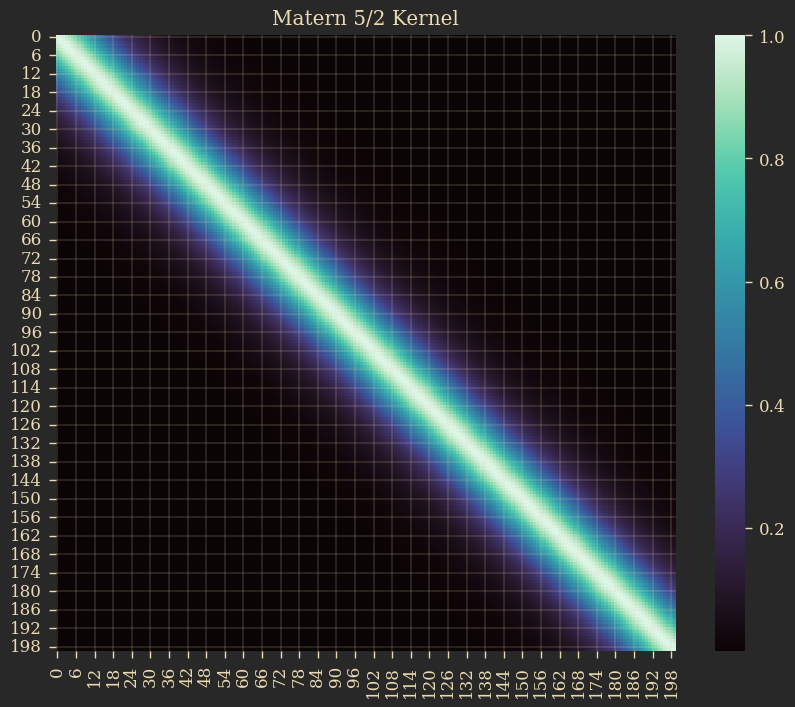

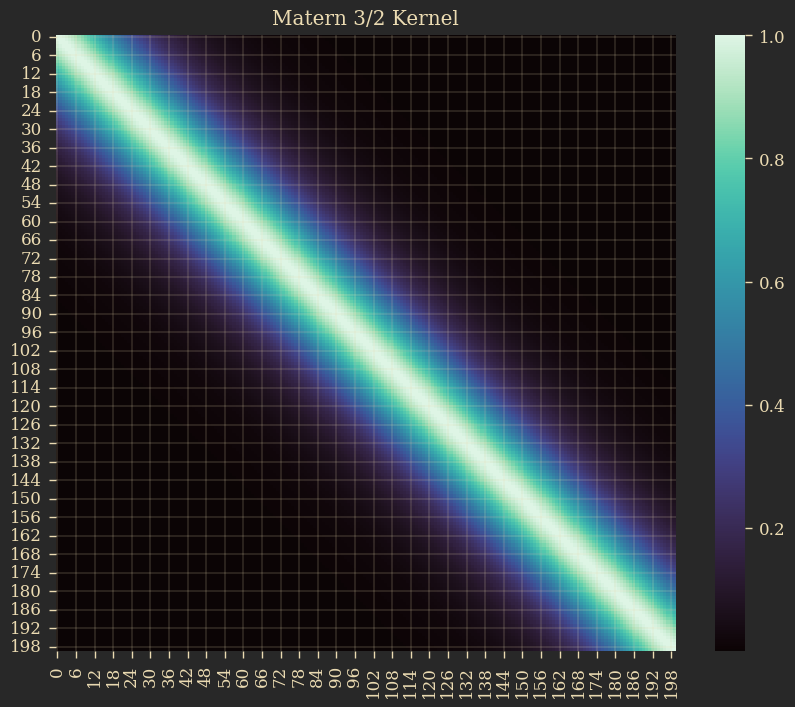

In [59]:
Kernel.visualise_kernel(cov_se, annotation=False, title="Squared Exponential Kernel")
Kernel.visualise_kernel(cov_me52, annotation=False, title="Matern 5/2 Kernel")
Kernel.visualise_kernel(cov_me32, annotation=False, title="Matern 3/2 Kernel")

### the data

In [60]:
n_ceft, cs2_ceft, cs2_l, cs2_u = anal.get_ceft_cs2()
phi_ceft_lower = get_phi(cs2_l)
phi_ceft_upper = get_phi(cs2_u)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_sigma = pc.CI_to_sigma(phi_ceft_width, 75)

cs2_hat = 0.3
sigma_hat = 1
l_hat = l_s

X_hat = 1.5

n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=200, mu_low=2.35, mu_high=2.75)
phi_pqcd_sigma = np.zeros_like(cs2_pqcd)


n_train = np.concatenate((n_ceft, n_pqcd))*ns
cs2 = np.concatenate((cs2_ceft, cs2_pqcd))


phi = pc.get_phi(cs2)
phi_sigma = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))

n_test = np.linspace(n[0], 40*ns, 200)

### posterior covs

In [61]:
gp_se = gaussianprocess.GP(kern_se, get_phi(cs2_hat))
gp_se.fit(n_train, n_test, phi, var_f = phi_sigma, stabilise=True)

gp_me32 = gaussianprocess.GP(kern_se, get_phi(cs2_hat))
gp_me32.fit(n_train, n_test, phi, var_f = phi_sigma, stabilise=True)

gp_me52 = gaussianprocess.GP(kern_se, get_phi(cs2_hat))
gp_me52.fit(n_train, n_test, phi, var_f = phi_sigma, stabilise=True)


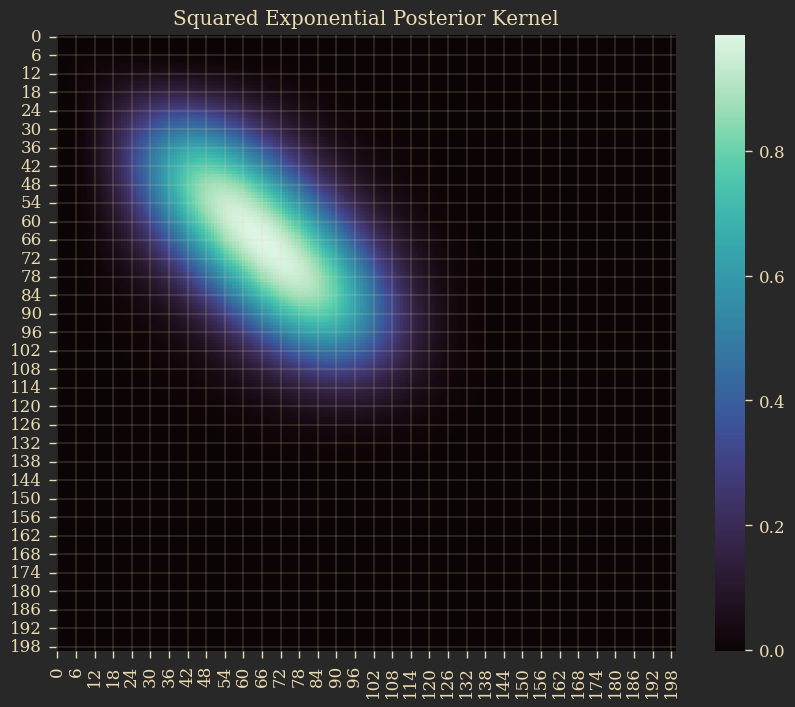

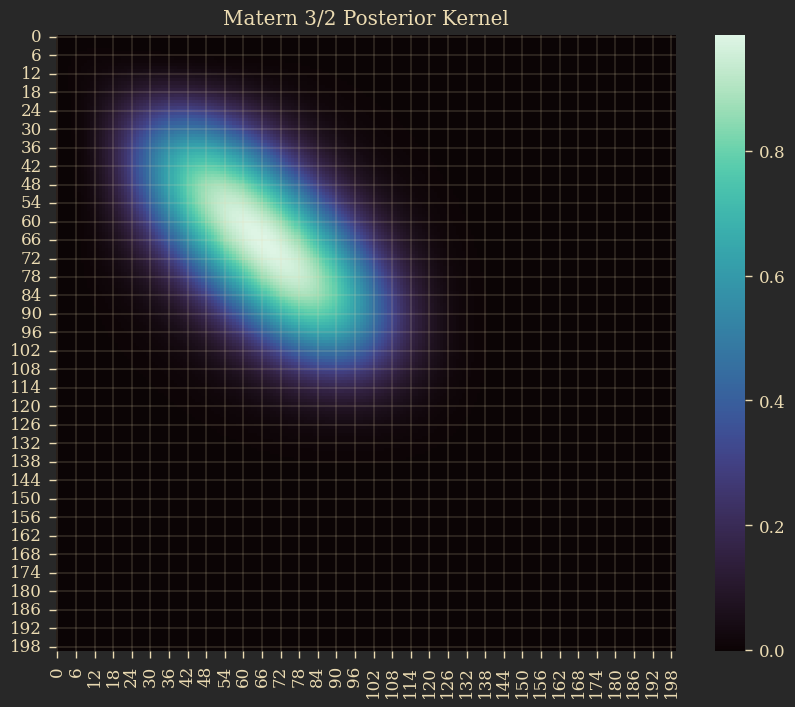

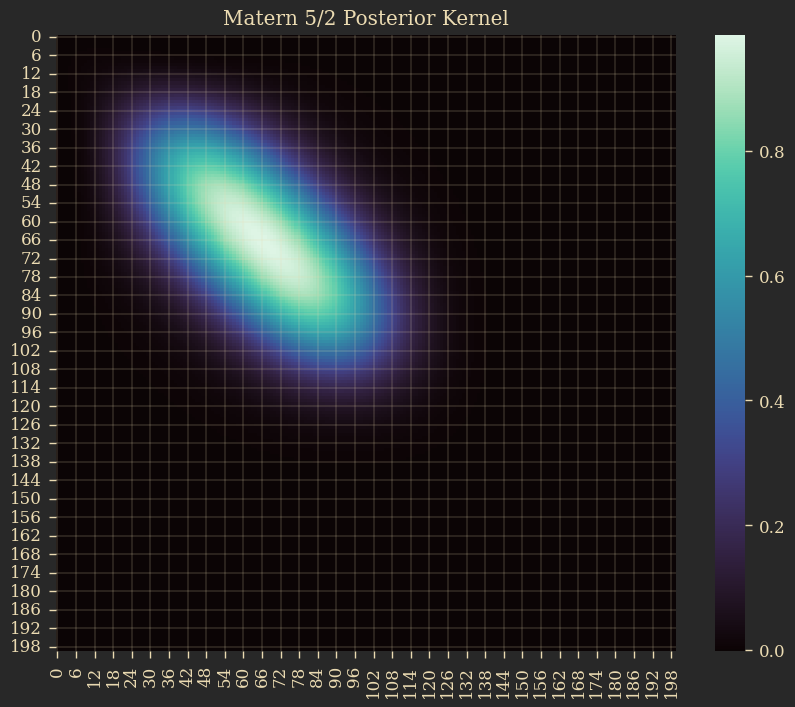

In [62]:
Kernel.visualise_kernel(gp_se.cov_star, annotation=False, title="Squared Exponential Posterior Kernel")
Kernel.visualise_kernel(gp_me32.cov_star, annotation=False, title="Matern 3/2 Posterior Kernel")
Kernel.visualise_kernel(gp_me52.cov_star, annotation=False, title="Matern 5/2 Posterior Kernel")

In [63]:
e0, p0,n0, mu0 = anal.get_ceft_ini()

flag = False
while not flag:
    phi_test_se = gp_se.posterior(sampling=True)
    eos_se = EosProperties(n_test, phi_test_se, epsi_0=e0, p_0=p0, mu_0=mu0)
    test_se = eos_se.get_all()

    if pp.check_pqcd_connection(X_hat, test_se["epsilon"][-1], test_se["pressure"][-1], 10):
        flag = True

flag = False
while not flag:
    phi_test_me32 = gp_me32.posterior(sampling=True)
    eos_me32 = EosProperties(n_test, phi_test_me32, epsi_0=e0, p_0=p0, mu_0=mu0)
    test_me32 = eos_me32.get_all()

    if pp.check_pqcd_connection(X_hat, test_me32["epsilon"][-1], test_me32["pressure"][-1], 10):
        flag = True

flag = False
while not flag:
  
    phi_test_me52 = gp_me52.posterior(sampling=True)
    eos_me52 = EosProperties(n_test, phi_test_me52, epsi_0=e0, p_0=p0, mu_0=mu0)
    test_me52 = eos_me52.get_all()

    if pp.check_pqcd_connection(X_hat, test_se["epsilon"][-1], test_se["pressure"][-1], 10):
        flag = True

plt.plot(n_test, test_se['cs2'], label='SE')
plt.plot(n_test, test_me32['cs2'], label='Matern 3/2')
plt.plot(n_test, test_me52['cs2'], label='Matern 5/2')
plt.xlabel(r"Number density (n_{sat})")
plt.ylabel(r"$C_{s}^{2}$")
plt.title(r"Matern 5/2 Sound Speed Squared")
plt.legend()
theme.apply_transforms()
plt.show()

plt.plot(n_test, test_se['pressure'], label='SE')
plt.plot(n_test, test_me32['pressure'], label='Matern 3/2')
plt.plot(n_test, test_me52['pressure'], label='Matern 5/2')
plt.yscale("log")
plt.xlabel(r"Number density (n_{sat})")
plt.ylabel(r"Pressure [MeV fm$^{-3}$]")
plt.title(r"Matern 5/2 EOS Set")
plt.ylim(1e-1,)
plt.legend()
theme.apply_transforms()
plt.show()


KeyboardInterrupt: 

Run SE,M52,M32

and store the l_hat too to compare if there is any bias